In [3]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
def extract_mel_spectrogram_resized(audio_path, sr=22050, n_mels=128, fmax=8000, target_size=(128, 128)):
    y, sr = librosa.load(audio_path, sr=sr)
    
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    resized_spectrogram = resize(log_mel_spectrogram, target_size, mode='reflect')
    
    return resized_spectrogram

In [7]:
def load_data(data_dir, folders, sr=22050, target_size=(128, 128)):
    X = []
    y = []
    
    for label_idx, label in enumerate(folders):
        folder_path = os.path.join(data_dir, label)
        
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)
                mel_spectrogram = extract_mel_spectrogram_resized(file_path, sr, target_size=target_size)
                
                X.append(mel_spectrogram)
                y.append(label_idx)
                
    X = np.array(X)
    y = np.array(y)
    
    X = np.expand_dims(X, axis=-1)
    
    return X, y

# Binary Classification

In [8]:
def build_cnn(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [9]:
data_dir = 'Binary_Classification'
folders = ['frustrated', 'delighted']

X, y = load_data(data_dir, folders, target_size=(128, 128))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c:\Users\Meghal\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1905
  warnings.warn(


In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [11]:
datagen.fit(X_train)

input_shape = (128, 128, 1)
model = build_cnn(input_shape)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_test)
)

c:\Users\Meghal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50


c:\Users\Meghal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.5202 - loss: 6.2156 - val_accuracy: 0.5587 - val_loss: 0.6919
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.5565 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5612 - loss: 0.6816 - val_accuracy: 0.5943 - val_loss: 0.6119
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.5550 - loss: 0.6532 - val_accuracy: 0.6210 - val_loss: 0.6134
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.5633 - loss: 0.6829 - val_accuracy: 0.6477 - val_loss: 0.6509
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.5715 - loss: 0.6829 - val_accuracy: 0.6619 - val_loss: 0.5718
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.6356 - loss: 0.6387 - val_accuracy: 0.6708 - val_loss: 0.5919
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.6507 - loss: 0.6368 - val_accuracy: 0.6655 - val_lo

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7405 - loss: 0.4913
Test accuracy: 76.87%


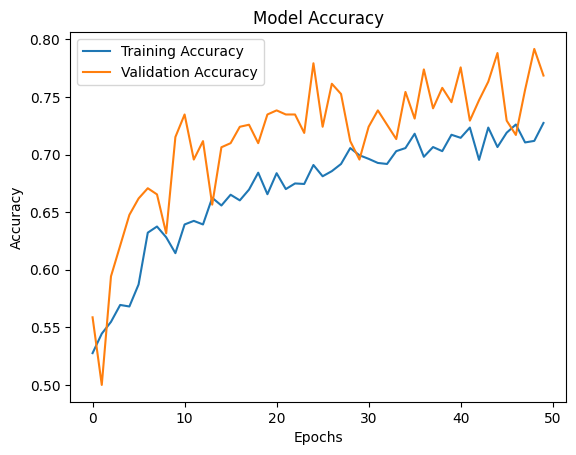

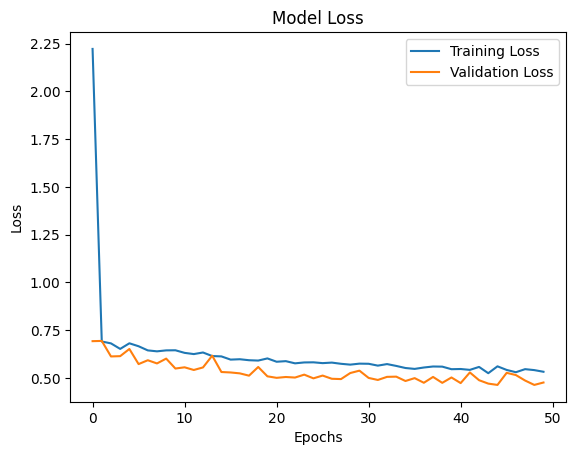

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Plot training history (accuracy and loss)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Multi Class Classification

In [16]:
def build_cnn(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
data_dir = 'Multi_Class_Classification'
folders =  ['frustrated', 'delighted', 'dysregulated', 'request', 'selftalk']

X_m, y_m = load_data(data_dir, folders, target_size=(128, 128))
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42)

c:\Users\Meghal\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1905
  warnings.warn(
c:\Users\Meghal\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1816
  warnings.warn(


In [18]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [19]:
datagen.fit(X_train_m)

input_shape = (128, 128, 1)
model = build_cnn(input_shape)

history = model.fit(
    datagen.flow(X_train_m, y_train_m, batch_size=32),
    epochs=50,
    validation_data=(X_test_m, y_test_m)
)

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.2910 - loss: 4.0250 - val_accuracy: 0.3162 - val_loss: 1.5176
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.3200 - loss: 1.5164 - val_accuracy: 0.3170 - val_loss: 1.4910
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.3193 - loss: 1.5112 - val_accuracy: 0.3170 - val_loss: 1.4872
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.3214 - loss: 1.4994 - val_accuracy: 0.3170 - val_loss: 1.4836
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.3175 - loss: 1.5021 - val_accuracy: 0.3170 - val_loss: 1.4800
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.3258 - loss: 1.5020 - val_accuracy: 0.3204 - val_loss: 1.4741
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.3218 - loss: 1.5005 - val_accuracy: 0.3170 - val_loss: 1.4866
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.3281 - loss: 1.4959 - 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3036 - loss: 1.4992
Test accuracy: 31.70%


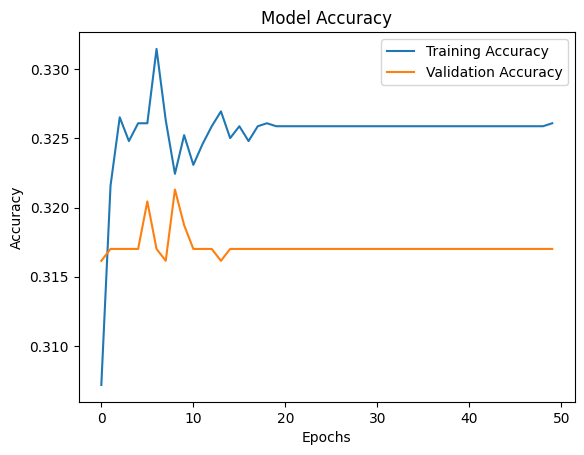

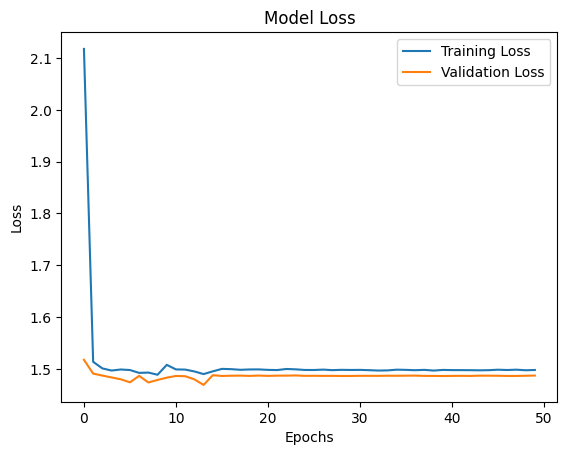

In [20]:
test_loss, test_acc = model.evaluate(X_test_m, y_test_m)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Plot training history (accuracy and loss)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()